# Affinity Propagation Clustering on Pypark

In [64]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

# Code

In [1]:
import numpy as np

In [2]:
from itertools import combinations_with_replacement

In [3]:
def euclidean_similarity(vector1,vector2):
    """Compute the Euclidean similarity (i.e : - Euclidean distance) between 2 vectors
    ----------------
    Parameter types:
    vector1: iterable
    vector2: iterable """
    sim = [(a - b)**2 for a, b in zip(vector1, vector2)]
    sim = -sum(sim)
    return(sim)

def parseLine(line, sep) :
    """ Parse the RDD
    ----------------
    Parameter types:
    line: string
    sep: string (ex: ',' or ';')"""
    parsed_line = line.split(sep)
    parsed_line =  [float(_) for _ in parsed_line]
    return(parsed_line)

def similarity_matrix_per_iterator(iterator, similarity_function):
    """ Compute the similarity matrix
    ----------------
    Parameter types:
    iterator: iterator from mapPartitions
    similarity_function: function (ex: euclidean_similarity)"""
    #Store partition in a list and reindex it
    partition = list(iterator)
    nb_elements = len(partition)
    ind = range(nb_elements)
    #Compute similarities
    similarity_matrix = np.empty([nb_elements, nb_elements]) #More efficient than np.zeros to initialize
    for item1,item2 in combinations_with_replacement(zip(ind, partition),2) :
        sim = similarity_function(item1[1][1:],item2[1][1:]) #compute similarity
        similarity_matrix[item1[0], item2[0]] = sim
        if item1[0] != item2[0]:
            similarity_matrix[item2[0], item1[0]] = sim
    return(nb_elements, ind, partition, similarity_matrix)

def add_preferences_to_similarity_matrix(similarity_matrix, preference_type ="median"):
    """ Update the preference value in the similarity matrix, i.e : updates the value of s(k,k)
    Several methods are available depending on the number of clusters expected by the user :
    -'median' : default method. Takes the median of the similarities as the preference value. 
    This method leads to a medium to large number of clusters
    -'minimum' : Takes the minimum of the similarities as the preference value. This method leads to a small number of clusters.
    -'random' : Takes a random number in the preference range mentioned in the article as the preference value. 
    ----------------
    Parameter types:
    similarity_matrix: symetric numpy array
    preference_type: string (only "median" is available for the moment)"""
    if preference_type == "median":
        preference_value = np.median(similarity_matrix)
    np.fill_diagonal(similarity_matrix, preference_value)

def update_responsibility_and_availability(similarity_matrix, responsibility_matrix, availability_matrix, ind, lambda_damping):
    """ Update the responsibility matrix and the availability matrix 
    ----------------
    Parameter types:
    similarity_matrix: symetric numpy array
    responsibility_matrix: numpy array
    availability_matrix: numpy array
    ind: list or numpy vector (list of the "new" index, i.e : index on the partition and not globally in the dataset)
    lambda_damping: float between 0 and 1"""
    #1. Update Responsibility
    temp_sum_availability_similarity = np.add(availability_matrix, similarity_matrix) #compute a(i,k) + s(i,k) for all i,k
    argmax_resp = np.argmax(temp_sum_availability_similarity, axis = 1 ) #compute argmax { a(i,k') + s(i,k') } on ALL k' when i is fixed
    max_resp =  temp_sum_availability_similarity[ind,argmax_resp][:,None] #NB : [:,None] converts the row of max values into a column
    #Compute the new r(i,k) when k is not equal to argmax { a(i,k') + s(i,k') }
    temp_responsibility_matrix = np.subtract(similarity_matrix,max_resp) 
    #Compute the new r(i,k) when k is equal to  argmax { a(i,k') + s(i,k') } :
    temp_sum_availability_similarity[ind,argmax_resp] = -np.inf #Set the (i,k)th element to -inf when k is an argmax for row i
    max_resp2 = np.max(temp_sum_availability_similarity, axis = 1) #compute new max for row i (the real max value of the row being set to -inf here)
    temp_responsibility_matrix[ind,argmax_resp] = similarity_matrix[ind,argmax_resp] - max_resp2
    #Damping
    responsibility_matrix = (1 - lambda_damping) * temp_responsibility_matrix + lambda_damping*responsibility_matrix
    #Remove temporary variables
    del temp_sum_availability_similarity
    del temp_responsibility_matrix
    
    #2. Update Availability for i != k
    temp_matrix = np.maximum(0, responsibility_matrix)
    temp_matrix = np.sum(temp_matrix, axis = 0) - temp_matrix #Compute el(i,k) = sum(max(0,r(i',k)) - max(0, r(i,k))
    temp_matrix_diag = temp_matrix.diagonal() #Store the updated a(k,k) values
    temp_matrix = np.minimum(0, responsibility_matrix.diagonal()) + temp_matrix
    temp_matrix = np.minimum(0, temp_matrix)

    #3. Update Availability for i ==k
    np.fill_diagonal(temp_matrix, temp_matrix_diag) #set the diagonal values to the updated a(k,k) values computed above
    
    #Damping
    availability_matrix = (1 - lambda_damping) * temp_matrix + lambda_damping*availability_matrix
    return(responsibility_matrix, availability_matrix)

def center_decision(responsibility_matrix, availability_matrix):
    """ Find the center chosen by each individual 
    (using the "new" index, i.e: the index on the partition and not the global index of the dataset)
    ----------------
    Parameter types:
    responsibility_matrix: numpy array
    availability_matrix: numpy array"""
    temp_matrix = responsibility_matrix + availability_matrix
    decision = np.argmax(temp_matrix, axis = 1)
    return(decision)

def affinity_propagation_clustering_per_partition(iterator, similarity_function = euclidean_similarity , preference_type ="median", 
                                                  lambda_damping = 0.5, max_iter = 200, max_unchange_count = 3):
    """
    Terminal conditions : max_iter or unchanged decisions for some number of iterations
    We need to add the terminal condition (2) of the article"""
    #1. Compute similarity matrix
    nb_elements, ind, partition, similarity_matrix = similarity_matrix_per_iterator(iterator, similarity_function)
    #similarity_matrix = convert_sim_to_numpy(nb_elements, similarity_matrix)
    #2. Compute preferences
    add_preferences_to_similarity_matrix(similarity_matrix, preference_type)
    #3. Initialize
    responsibility_matrix = np.zeros([nb_elements, nb_elements]) 
    availability_matrix = np.zeros([nb_elements, nb_elements])
    decision = ind
    unchange_count = 0
    #4. Update responsibility and availability until one of the terminal conditions is met
    for it in xrange(max_iter) :
        responsibility_matrix, availability_matrix = update_responsibility_and_availability(similarity_matrix, responsibility_matrix, 
                                                                                            availability_matrix, ind, lambda_damping)
        temp_decision = center_decision(responsibility_matrix, availability_matrix)
        if np.array_equal(temp_decision, decision) : 
            unchange_count = unchange_count + 1
            if unchange_count >=  max_unchange_count :
                decision = temp_decision
                break
        else: 
            decision = temp_decision
    #5. Aggregate points with the same centers and add the center coordinates (using the initial index)
    decision = sorted(zip(decision, ind), key = lambda x : x[0])
    from itertools import groupby
    output = list()
    for key, group in groupby(decision, lambda x: x[0]):
        output.append((partition[key][0], [partition[j][0] for i,j in group], partition[key][1:], similarity_matrix[0,0]))
    return(output)

In [4]:
def getRoots3(aNeigh):
    """ Connected Components Research in a Graph
    ----------------
    Parameter types:
    aNeigh: graph repesented by a dictionnary with key = node and value = list of connected nodes """
    def findRoot(aNode,aRoot):
        while aNode != aRoot[aNode][0]:
            aNode = aRoot[aNode][0]
        return (aNode,aRoot[aNode][1])
    myRoot = {} 
    for myNode in aNeigh.keys():
        myRoot[myNode] = (myNode,0)  
    for myI in aNeigh: 
        for myJ in aNeigh[myI]: 
            (myRoot_myI,myDepthMyI) = findRoot(myI,myRoot) 
            (myRoot_myJ,myDepthMyJ) = findRoot(myJ,myRoot) 
            if myRoot_myI != myRoot_myJ: 
                myMin = myRoot_myI
                myMax = myRoot_myJ 
                if  myDepthMyI > myDepthMyJ: 
                    myMin = myRoot_myJ
                    myMax = myRoot_myI
                myRoot[myMax] = (myMax,max(myRoot[myMin][1]+1,myRoot[myMax][1]))
                myRoot[myMin] = (myRoot[myMax][0],-1) 
    myToRet = {}
    for myI in aNeigh: 
        myToRet[myI] = findRoot(myI,myRoot)[0]
    return myToRet  

In [55]:
def affinity_propagation_clustering(name_file, sep = ',', cluster_aggregation_parameter = 0.5, similarity_function = euclidean_similarity,
                                   preference_type ="median", lambda_damping = 0.5, max_iter = 200, max_unchange_count = 3):
    """ Create an RDD from a text file and return the Affinity Propagation Clustering result 
    ----------------
    Parameter types:
    name_file: string (path to text file) """
    rdd = sc.textFile(name_file)
    rdd = rdd.map(lambda line : parseLine(line, sep))
    #1. Affinity Propagation Clustering on each partition
    rdd2 = rdd.mapPartitions(lambda iterator : affinity_propagation_clustering_per_partition(iterator, 
                                                                                             similarity_function = euclidean_similarity , 
                                                                                             preference_type = preference_type, 
                                                                                             lambda_damping = lambda_damping, 
                                                                                             max_iter = max_iter, 
                                                                                             max_unchange_count = max_unchange_count), 
                         preservesPartitioning=True)
    #2. Compute similarities between all centers
    rdd_dist = rdd2.cartesian(rdd2).map(lambda u : ((u[0][0], u[1][0]),euclidean_similarity(u[0][2], u[1][2]),
                                     cluster_aggregation_parameter*((u[0][3] + u[1][3])/2)))
    #3. Filter centers which are close to each other (the threshold depends on the preference values and the cluster_aggregation_parameter)
    edges = rdd_dist.filter(lambda u : u[1] > u[2]).map(lambda u: u[0])
    #4. Format the selected centers as the nodes of a graph where there is an edge is their similarity was higher than the threshold
    edges = edges.map(lambda nameTuple: (nameTuple[0], [ nameTuple[1] ])) \
    .reduceByKey(lambda a, b: a + b)  # combine lists: ([1,2,3] + [4,5]) becomes [1,2,3,4,5]
    #5. Collect results on the master CPU and find the connected components on the graph (centers that need to be aggregated in one center)
    connected_components = getRoots3(dict(edges.collect()))
    #6. Broadcast the results from the master to the workers
    connected_components_broadcast = sc.broadcast(connected_components)
    #7. Assign the new centers to the Affinity Propagation Clustering on each partition results
    rdd3 = rdd2.map(lambda (center, points, coordinates, preference) : (connected_components_broadcast.value[center], points))
    #8. Aggregate the lists of points that belong to the same cluster (same center = same key)
    result_clustering = rdd3.reduceByKey(lambda a, b: a + b)
    return(result_clustering)

# Présentation de l'algorithme distribué Affinity Propagation sur les données Iris

Comme les auteurs de l'article, nous utilisons le petit jeu de données Iris dans un premier temps pour tester l'algorithme.

Avant d'utiliser ces données, il faut d'abord les indexer puisque PySpark ne stocke pas de position sous le format RDD. Il faut également supprimer les labels (le type d'iris). Enfin, les données sont ordonnées par type de fleur : il faut donc effectuer un shuffle en amont.

In [8]:
import random

In [9]:
def index_dataset(in_filename, out_filename, sep = ','):   
    with open(out_filename, 'w') as output_file:
        with open(in_filename, 'r') as input_file :
            lines = list(input_file)
            random.seed( 3 )
            random.shuffle(lines)
            for i,line in enumerate(lines) :
                without_label = line.split(',')[:-1]
                output_line = str(i) +',' + ','.join(without_label) + '\n'
                output_file.write(output_line)
        

In [10]:
index_dataset("iris_data.txt", "iris_data_indexed.txt", sep = ',')

Nous stockons maintenant les données dans un RDD. A ce stade, elles sont donc découpées et réparties entre un certain nombre de CPU.

In [6]:
rdd = sc.textFile("iris_data_indexed.txt")

Regardons en combien de partitions (nombre de CPU) les données sont réparties :

In [5]:
rdd.getNumPartitions()

2

Regardons enfin à quoi ressemble le RDD obtenu :

In [6]:
res = rdd.collect()
res[:2]

[u'0,6.7,2.5,5.8,1.8', u'1,4.9,2.4,3.3,1.0']

Nous remarquons que Spark stocke par défaut les données provenant d'un fichier texte sous frome de string. Ainsi, nous devrons préalablement parser chaque ligne du jeu de données : c'est ce que fait la fonction parseLine.

Dans la suite de ce notebook, nous présenterons plus en détail chacune des fonctions définies plus haut afin notamment de bien comprendre le format des données résultant de chaque étape. Nous les regrouperons ensuite dans un module afin de pouvoir les utiliser plus facilement sur d'autres jeux de données.

## 1. Affinity Propagation Clustering sur chaque partition

### parseLine

In [7]:
parseLine("5,6", sep = ',')

[5.0, 6.0]

In [7]:
rdd = rdd.map(lambda line : parseLine(line, ','))

Observons le résultat de la fonction parseLine mappée sur chaque élément du RDD :

In [9]:
rdd.collect()[:3]

[[0.0, 6.7, 2.5, 5.8, 1.8],
 [1.0, 4.9, 2.4, 3.3, 1.0],
 [2.0, 7.1, 3.0, 5.9, 2.1]]

### similarity_matrix_per_iterator

Cette foncion permet de calculer la matrice de similarité entre les individus répartis dans chaque CPU séparément, **l'idée de l'article étant de réaliser indépendamment plusieurs Affinity Propagation Clustering sur chaque CPU avant de les agréger** par la suite. Ici, concrètement, un même individu est donc présent sur un seul des CPU et donc sur une seule des matrices de similarité.

Cette fonction renvoie également des objets dont nous aurons besoin par la suite : le nombre d'individus sur le CPU (nécessaire pour initialiser des matrices numpy), la liste des nouveaux index des individus du CPU (i.e une liste de 0 au nombre d'individus présents sur le CPU) et les coordonnées de chaque individus présents sur le CPU (les données initiales du RDD).

**Pourquoi avoir choisi de renvoyer autant d'objets ?**
Il faut d'abord noter que cette fonction a vocation à être utilisée à l'intérieur d'une fonction plus globale "affinity_propagation_clustering_per_partition" qui sera appliquée directement à chaque partititon et qui renverra le résultat de l'Affinity Propagation Clustering réalisé sur cette partition. Elle n'a donc pas vocation à être utilisée directement dans une opération map, mais en local sur chaque CPU séparément. Ces différents objets seront donc stockés en mémoire dans chaque CPU tout au long de l'Affinity Propagation Clustering local.

Un **inconvénient** de cette démarche est qu'on n'utilise pas la "bonne propriété" de Spark qui est le **"lineage"** : en imbriquant plusieurs opérations de type map, Spark conserve un pointeur vers le RDD parent sur lequel on applique le map. Concrètement, une sorte d'historique des transformations est conservé de façon à en particulier recalculer les données en cas de problème. Comme ici nous n'allons utiliser qu'une seule opération mapPartitions pour l'ensemble de l'Affinity Propagation Clustering de chaque CPU, en cas d'échec nous ne bénéficions que très peu de ceci.

L'**autre inconvénient majeur**, qui est entièrement lié, est qu'on n'utilise pas l'optimisation de la mémoire automatiquement effectuée par Spark entre les différentes étapes du lineage. Comme les opérations map ne sont évaluées qu'au moment où elles sont utilisées (**"lazy evaluation"**), Spark est capable d'optimiser l'usage de la mémoire des différents CPU au moment de l'action d'évaluation. Ici, au contraire, nous forçons le stockage en mémoire d'un certain nombre d'informations sur les différents CPU qui ne seront d'ailleurs pas utilisées entièrement: typiquement, seules les coordonnées des centres qui ressortiront du clustering dans l'objet partition nous intéressent. 

**Alors pourquoi avoir fait ce choix ?**
La difficulté majeure que nous avons rencontrée est que nous utilisons deux index pour qualifier les individus observés : un **index "global"** qui est l'index présent dans le jeu de données initial et qui est unique dans tout le jeu de données, et un **index "local"** qui correspond à la position dans la matrice de similarité locale (puis dans les matrices de disponibilité et de responsabilité). En effet, chaque CPU traite ses propres individus et construit sa propre matrice de similarité. Il fallait donc conserver un lien entre ces deux index afin de pouvoir renvoyer des résultats utilisant l'index global (le "vrai" index). C'est donc la solution **la plus facile** que nous avons trouvé. Nous évitions ainsi des opérations coûteuses de type join. Cette solution n'est donc effectivement **probablement pas optimale**.




In [10]:
rdd.mapPartitions(lambda iterator : similarity_matrix_per_iterator(iterator, euclidean_similarity), 
                  preservesPartitioning=True).glom().collect()

[[77,
  [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   74,
   75,
   76],
  [[0.0, 6.7, 2.5, 5.8, 1.8],
   [1.0, 4.9, 2.4, 3.3, 1.0],
   [2.0, 7.1, 3.0, 5.9, 2.1],
   [3.0, 6.0, 2.9, 4.5, 1.5],
   [4.0, 4.6, 3.4, 1.4, 0.3],
   [5.0, 5.1, 3.8, 1.9, 0.4],
   [6.0, 5.2, 3.4, 1.4, 0.2],
   [7.0, 5.7, 2.8, 4.5, 1.3],
   [8.0, 5.1, 2.5, 3.0, 1.1],
   [9.0, 6.5, 3.0, 5.8, 2.2],
   [10.0, 5.1, 3.7, 1.5, 0.4],
   [11.0, 6.3, 2.5, 4.9, 1.5],
   [12.0, 6.2, 3.4, 5.4, 2.3],
   [13.0, 5.6, 2.7, 4.2, 1.3],
   [14.0, 5.0, 3.6, 1.4, 0.2],
   [15.0,

La commande glom() nous permet d'identifier quelles données sont regroupées dans le même CPU. Nous voyons donc ici que le CPU 1 contient 77 observations alors que le CPU 2 en contient 73. Nous remarquons aussi que pour l'instant les diagonales des matrices de similarités sont nulles (similarité entre un individu et lui-même).

### add_preferences_to_similarity_matrix

Cette fonction sert à transformer les diagonales des matrices de similarité de chaque CPU afin de leur attribuer une valeur qu'on appelle **préférence**. Cette valeur indique en quelque sort la **propension de l'individu à se choisir lui-même en tant que centre**. Ceci va donc aussi déterminer le nombre de clusters que renvoie chaque Affinity Propagation Clustering sur chaque CPU séparément: si la préférence est élevée, les individus vont avoir tendance à vouloir se choisir eux-mêmes comme centre et on obtient alors un plus grand nombre de clusters.

Comme le précise l'article, il existe plusieurs façons de déterminer cette préférence. Utiliser la médiane des similarités préalablement calculées est la stratégie la plus commune et donc celle que nous avons codé ici. Néanmoins, il est tout à fait possible d'en ajouter d'autres, permettant d'obtenir plus ou moins de clusters à la fin.

Notons enfin que chaque CPU a sa propre matrice de similarité, donc sa propre valeur de préférence et il n'y a aucune raison qu'elles soient égales entre les CPU.

### update_responsibility_and_availability

Cette fonction permet de mettre à jour les matrices de responsabilité et de disponibilité à chaque itération de l'algorithme de clustering sur le CPU. Nous effectuons ici un certain nombre de calculs pour simplifier les notations indiquées par l'article : 

Mise à jour de la matrice de responsabilité : 
$$ r(i,k)  = s(i,k) - max_{k' \neq k}\{a(i,k') + s(i,k')\} $$
Mise à jour des coefficients de la matrice de disponibilité lorsque $i \neq k$ : 
$$ a(i,k) = min\{0, r(k,k) + \sum_{i' \neq i, i' \neq k} max\{0, r(i',k)\} \} $$
$$ a(i,k) = min\{0, r(k,k) + \sum_{i'} max\{0, r(i',k)\} - max\{0, r(i,k)\} - max\{0, r(k,k)\}\} $$
Or $r(k,k) - max\{0, r(k,k)\} = 0$ si $r(k,k) > 0$ et   $r(k,k) - max\{0, r(k,k)\} = r(k,k)$ si $r(k,k) \leq 0$
d'où : $r(k,k) - max\{0, r(k,k)\} = min\{0, r(k,k)\}$
$$ a(i,k) = min\{0,min\{0, r(k,k)\} + \sum_{i'} max\{0, r(i',k)\} - max\{0, r(i,k)\} \}\}  $$
Mise à jour des coefficients de la matrice de disponibilité lorsque $i = k$ :
$$ a(k,k) = \sum_{i'} max\{0, r(i',k)\} - max\{0, r(k,k) \}$$

Notre code est inspiré (mais pas identique!) du code de l'Affinity Propagation Clustering de scikit-learn disponible sur Github ici: https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/cluster/affinity_propagation_.py

On comprend bien à l'aide des calculs ci-dessus l'intérêt du choix de stocker les similarités, responsabilités et disponibilités sous forme de numpy array : accéder aux bons coefficients est facile à coder, rapide et surtout, le calcul des maximum et des minimums par rapport à une ligne ou une colonne est rapide.

Initialement, nous avions notamment essayé de stocker la matrice de similarité sous forme de 3 colonnes (i,j, valeur) afin notamment d'économiser en termes de mémoire puisqu'il s'agit d'une matrice symétrique mais ce format de données s'est rapidement avérée compliqué à manipuler.

Le fait de voir que les contributeurs de scikiy-learn avaient fait ce choix nous a aussi conforté dans l'idée d'utiliser numpy.

### affinity_propagation_clustering_per_partition

Cette fonction regroupe alors toutes les fonctions présentées plus haut afin de réaliser l'Affinity Propagation Clustering séparément sur chaque partition.

In [8]:
rdd2 = rdd.mapPartitions(lambda iterator : affinity_propagation_clustering_per_partition(iterator, similarity_function = euclidean_similarity), 
                         preservesPartitioning=True)

In [47]:
rdd2.collect()

[(2.0,
  [0.0,
   2.0,
   9.0,
   18.0,
   19.0,
   23.0,
   25.0,
   34.0,
   40.0,
   41.0,
   46.0,
   52.0,
   56.0,
   58.0,
   62.0,
   74.0],
  [7.1, 3.0, 5.9, 2.1],
  -5.9399999999999977),
 (32.0,
  [1.0, 7.0, 8.0, 13.0, 30.0, 32.0, 49.0, 64.0, 69.0, 71.0, 72.0, 75.0],
  [5.7, 2.8, 4.1, 1.3],
  -5.9399999999999977),
 (55.0,
  [4.0,
   5.0,
   6.0,
   10.0,
   14.0,
   15.0,
   16.0,
   17.0,
   20.0,
   22.0,
   24.0,
   26.0,
   27.0,
   28.0,
   35.0,
   36.0,
   39.0,
   42.0,
   45.0,
   48.0,
   50.0,
   53.0,
   55.0,
   57.0,
   61.0,
   63.0,
   67.0,
   70.0,
   73.0],
  [5.1, 3.5, 1.4, 0.3],
  -5.9399999999999977),
 (66.0,
  [3.0,
   11.0,
   12.0,
   21.0,
   29.0,
   31.0,
   33.0,
   37.0,
   38.0,
   43.0,
   44.0,
   47.0,
   51.0,
   54.0,
   59.0,
   60.0,
   65.0,
   66.0,
   68.0,
   76.0],
  [6.2, 2.8, 4.8, 1.8],
  -5.9399999999999977),
 (78.0,
  [78.0,
   79.0,
   85.0,
   90.0,
   94.0,
   100.0,
   103.0,
   109.0,
   113.0,
   118.0,
   121.0,
   123.0,


Les résultats sont comme on le voit renvoyés sous le format d'un tuple de 4 élements :
* Index global du centre
* Liste des index globaux des individus qui sont affectés à ce centre
* Coordonnées du centre
* Valeur de préférence utilisée sur le CPU qui a renvoyé ce centre

La valeur de préférence est conservée ici car, comme on le verra lors de l'agrégation (partie 2), nous en aurons besoin pour déterminer le seuil à partir duquel nous choisissons de regrouper 2 clusters.

Encore une fois, nous sommes conscients qu'ici nous stockons une même valeur plusieurs fois mais cela simplifie les opérations suivantes. De plus, un nombre relativement limité de centres (= nombre de clusters) est théoriquement renvoyé par chaque CPU comparé au nombre d'individus. La différence en termes de stockage ne devrait donc pas non plus poser problème sur de grosses bases de données.

** Visualisation des résultats intermédiaires **

In [9]:
rdd_vis_intermed = rdd2.map(lambda x : (x[0], x[1]), preservesPartitioning=True)

In [10]:
#Results of the clustering on the first CPU
res_intermed_0 = rdd_vis_intermed.flatMap(lambda (center, points) : [(point, center) for point in points]).glom().collect()[0]
#Results of the clustering on the second CPU
res_intermed_1 = rdd_vis_intermed.flatMap(lambda (center, points) : [(point, center) for point in points]).glom().collect()[1]

In [11]:
import pandas as pd
df_res_intermed_0 = pd.DataFrame(res_intermed_0)
df_res_intermed_0.columns=['Index', 'Cluster']
df_res_intermed_1 = pd.DataFrame(res_intermed_1)
df_res_intermed_1.columns=['Index', 'Cluster']
df_res_intermed_0.head()

,Index,Cluster
0,0.0,2.0
1,2.0,2.0
2,9.0,2.0
3,18.0,2.0
4,19.0,2.0


In [12]:
data_df = pd.read_csv("iris_data_indexed.txt", header = None)
data_df.columns = ["Index", "Sepal.Length", "Sepal.Width", "Petal.Length", "Petal.Width"]
data_df.head()

,Index,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
0,0,6.7,2.5,5.8,1.8
1,1,4.9,2.4,3.3,1.0
2,2,7.1,3.0,5.9,2.1
3,3,6.0,2.9,4.5,1.5
4,4,4.6,3.4,1.4,0.3


In [13]:
final_df_intermed_0 = pd.merge(data_df, df_res_intermed_0, left_on = "Index", right_on = "Index")
final_df_intermed_1 = pd.merge(data_df, df_res_intermed_1, left_on = "Index", right_on = "Index")
final_df_intermed_0.head()

,Index,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Cluster
0,0,6.7,2.5,5.8,1.8,2.0
1,1,4.9,2.4,3.3,1.0,32.0
2,2,7.1,3.0,5.9,2.1,2.0
3,3,6.0,2.9,4.5,1.5,66.0
4,4,4.6,3.4,1.4,0.3,55.0


In [14]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  

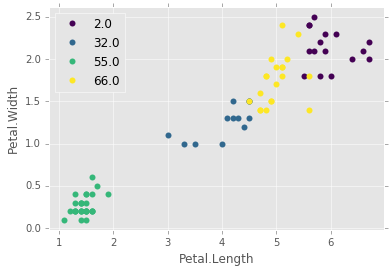

In [33]:
groups = final_df_intermed_0.groupby('Cluster')

# Plot
colors = pd.tools.plotting._get_standard_colors(len(groups), colormap='viridis')

fig, ax = plt.subplots()
ax.set_color_cycle(colors)
ax.margins(0.05)
for name, group in groups:
    ax.plot(group['Petal.Length'], group['Petal.Width'], marker='o', linestyle='', ms=6, markeredgewidth=0.0, label=name)
ax.legend(numpoints=1, loc='upper left')
ax.set_xlabel('Petal.Length')
ax.set_ylabel('Petal.Width')

plt.show()

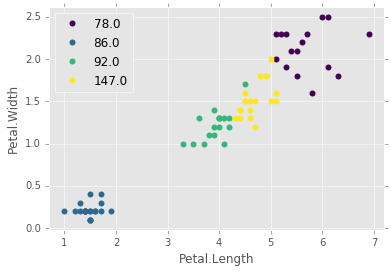

In [34]:
groups = final_df_intermed_1.groupby('Cluster')

# Plot
colors = pd.tools.plotting._get_standard_colors(len(groups), colormap='viridis')

fig, ax = plt.subplots()
ax.set_color_cycle(colors)
ax.margins(0.05)
for name, group in groups:
    ax.plot(group['Petal.Length'], group['Petal.Width'], marker='o', linestyle='', ms=6, markeredgewidth=0.0, label=name)
ax.legend(numpoints=1, loc='upper left')
ax.set_xlabel('Petal.Length')
ax.set_ylabel('Petal.Width')

plt.show()

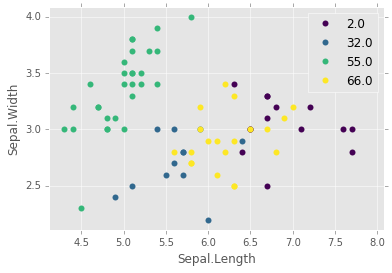

In [35]:
groups = final_df_intermed_0.groupby('Cluster')

# Plot
colors = pd.tools.plotting._get_standard_colors(len(groups), colormap='viridis')

fig, ax = plt.subplots()
ax.set_color_cycle(colors)
ax.margins(0.05)
for name, group in groups:
    ax.plot(group['Sepal.Length'], group['Sepal.Width'], marker='o', linestyle='', ms=6, markeredgewidth=0.0, label=name)
ax.legend(numpoints=1, loc='upper right')
ax.set_xlabel('Sepal.Length')
ax.set_ylabel('Sepal.Width')

plt.show()

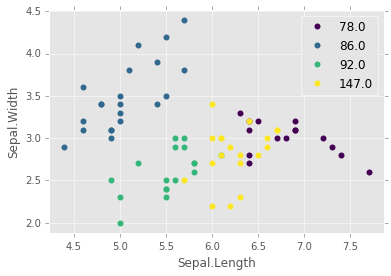

In [36]:
groups = final_df_intermed_1.groupby('Cluster')

# Plot
colors = pd.tools.plotting._get_standard_colors(len(groups), colormap='viridis')

fig, ax = plt.subplots()
ax.set_color_cycle(colors)
ax.margins(0.05)
for name, group in groups:
    ax.plot(group['Sepal.Length'], group['Sepal.Width'], marker='o', linestyle='', ms=6, markeredgewidth=0.0, label=name)
ax.legend(numpoints=1, loc='upper right')
ax.set_xlabel('Sepal.Length')
ax.set_ylabel('Sepal.Width')

plt.show()

On constate que le deuxième CPU identifie 4 clusters relativement séparés sur les 2 graphiques, alors que le premier CPU identifie 4 clusters beaucoup moins bien séparés sur le second graphique, qui concerne la longueur et la largeur des sépales.

## 2. Agrégation des résultats des clusterings

Nous allons présenter ici la démarche pas à pas d'agrégation des résultats entre les clusters. Toutes ces opérations sont regroupées au sein de la fonction "affinity_propagation_clustering" définie au début.

L'idée principale de l'article est de limiter au maximum le nombre de communications entre les CPU : c'est pour cela qu'au lieu d'effectuer un seul clustering sur plusieurs CPU à la fois, nous effectuons un clustering différent sur chaque CPU. **Les résultats sont ensuite agrégés en regroupant en un seul cluster les points dont les centres sont "proches".**

Notons que les auteurs de l'article de donnent quasiment aucune indication sur la procédure à suivre pour en pratique "agréger" ces clusters trop proches, et que ceci est en réalité plus complexe que cela n'en a l'air, comme on le verra par la suite.

### Calcul des similarités entre les centres

La première étape est donc d'identifier quels sont les centres proches 2 à 2 : il faut donc calculer la similarités entre tous les centres obtenus à l'issue des différents clusterings.

L'article conseille de regrouper les centres dont la similarité est supérieure à 0.5 fois la valeur de préférence, sans donner plus de détails. Nous profitons donc du calcul des similarités pour aussi calculer le valeur du seuil. Nous choisissons donc d'utiliser ici un seuil égal à cluster_aggregation_parameter fois la moyenne des valeurs de préférences du CPU dont sont issus chacun des deux centres. Pour l'instant, nous fixons cluster_aggregation_parameter à 0.5, mais, comme on le verra par la suite sur les résultats sur le jeu de données Iris, il semble préférable de laisser ce choix à l'utilisateur afin de pouvoir moduler le nombre de clusters final.

In [37]:
cluster_aggregation_parameter = 0.5

In [38]:
rdd_dist = rdd2.cartesian(rdd2).map(lambda u : ((u[0][0], u[1][0]),euclidean_similarity(u[0][2], u[1][2]),
                                     cluster_aggregation_parameter*((u[0][3] + u[1][3])/2)))

In [39]:
rdd_dist.collect()[:3]

[((2.0, 2.0), -0.0, -2.9699999999999989),
 ((2.0, 32.0), -5.880000000000001, -2.9699999999999989),
 ((2.0, 55.0), -27.740000000000002, -2.9699999999999989)]

### Sélection des centres qui doivent être regroupés 2 à 2

Nous filtrons ici les centres que nous souhaitons regrouper : ceux dont la similarité est supérieure au seuil calculé.

In [40]:
edges = rdd_dist.filter(lambda u : u[1] > u[2]).map(lambda u: u[0])
edges.collect()[:5]

[(2.0, 2.0), (2.0, 66.0), (32.0, 32.0), (55.0, 55.0), (32.0, 66.0)]

Comme on le voit ici, le regroupement est loin d'être évident car un même centre peut devoir être regroupé avec plusieurs centres, comme par exemple le centre 2, le centre 32 et le centre 66.

Nous modifions dont le format des données avec une opérations reduceByKey : nous présentons les données sous forme d'un graphe. Chaque centre est un noeud auquel on associe la liste des centres auxquels il doit être regroupé.

In [41]:
edges = edges.map(lambda nameTuple: (nameTuple[0], [ nameTuple[1] ])) \
.reduceByKey(lambda a, b: a + b)  # combine lists: ([1,2,3] + [4,5]) becomes [1,2,3,4,5]

edges.collect()

[(32.0, [32.0, 66.0, 92.0, 147.0]),
 (92.0, [32.0, 66.0, 92.0, 147.0]),
 (2.0, [2.0, 66.0, 78.0, 147.0]),
 (78.0, [2.0, 66.0, 78.0, 147.0]),
 (66.0, [2.0, 32.0, 66.0, 78.0, 92.0, 147.0]),
 (86.0, [55.0, 86.0]),
 (147.0, [2.0, 32.0, 66.0, 78.0, 92.0, 147.0]),
 (55.0, [55.0, 86.0])]

Ces couples key-value peuvent être facilement convertis en dictionnaire Python : 

In [42]:
dict(edges.collect())

{2.0: [2.0, 66.0, 78.0, 147.0],
 32.0: [32.0, 66.0, 92.0, 147.0],
 55.0: [55.0, 86.0],
 66.0: [2.0, 32.0, 66.0, 78.0, 92.0, 147.0],
 78.0: [2.0, 66.0, 78.0, 147.0],
 86.0: [55.0, 86.0],
 92.0: [32.0, 66.0, 92.0, 147.0],
 147.0: [2.0, 32.0, 66.0, 78.0, 92.0, 147.0]}

### Formulation du problème d'agrégation en un problème de recherche de connected components au sein d'un graphe

Comme on le voit, le problème est maintenant d'attribuer la même clé à tous des centres devant être regroupés en un seul, et ceci est loin d'être le résultat d'une transformation évidente.
Nous pouvons représenter nos centres devant être agrégés sous forme de graphe, où chaque centre correspond à un noeud et où les centres devant être agrégés sont reliés par une arête :

In [43]:
import networkx as nx
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [44]:
G=nx.Graph(dict(edges.collect()))

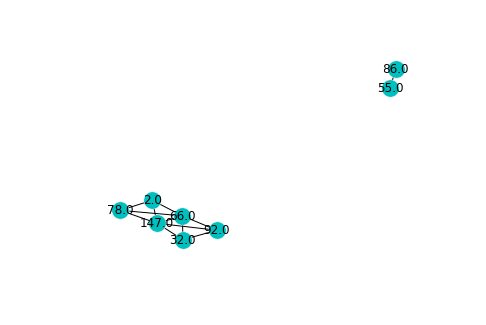

In [45]:
nx.draw(G, node_color='c',edge_color='k', with_labels=True)

On comprend ici que nous aboutissons à deux clusters en procédant à une agrégation. Nous devons donc maintenant écrire une fonction capable de mettre en évidence ces sous-graphes, c'est-à-dire attribuer la même clé aux noeuds appartenant au même sous-graphe. Ceci correspond au problème qu'on appelle la recherche des "connected components" en théorie des graphe.

Nous nous reprenons donc en grande partie une des fonctions mentionnées ici : http://stackoverflow.com/questions/10301000/python-connected-components

Notons cependant qu'utiliser ce type de fonction implique en pratique de **rapatrier sur le CPU master les données contenues dans "edges.collect()"**, c'est-à-dire le graphe dont nous avons fait la représentation graphique ci-dessus. Ceci ne devrait dans la plupart des cas pas poser de problème car il s'agit uniquement d'un nombre restreint d'index. La taille de ces données en termes de stockage ne dépend ainsi pas du nombre de variables disponible dans le le jeu de données initial et contient a priori un petit nombre de lignes car peu de centres sont mis en évidence et peu doivent être agrégés.

Néanmoins, nous aurions effectivement pu réfléchir à une version distribuée de la recherche des connected components. Nous savons qu'il en existe une version déjà implementée sur Spark dans le package GraphFrames mais nous n'avons pas réussi à l'installer (le package est compris dans l'installation de Spark pour le langage Scala mais pas pour le langage Python). Cependant, comme évoqué ci-dessus, le fait de tout effectuer sur le master n'est pas forcément un mauvais choix en termes de performance car cela évite un certain nombre de coûts de communication. Il aurait idéalement fallu comparer les performances sur un véritable cluster de CPU avec plusieurs bases de données.

In [46]:
def getRoots3(aNeigh):
    def findRoot(aNode,aRoot):
        while aNode != aRoot[aNode][0]:
            aNode = aRoot[aNode][0]
        return (aNode,aRoot[aNode][1])
    myRoot = {} 
    for myNode in aNeigh.keys():
        myRoot[myNode] = (myNode,0)  
    for myI in aNeigh: 
        for myJ in aNeigh[myI]: 
            (myRoot_myI,myDepthMyI) = findRoot(myI,myRoot) 
            (myRoot_myJ,myDepthMyJ) = findRoot(myJ,myRoot) 
            if myRoot_myI != myRoot_myJ: 
                myMin = myRoot_myI
                myMax = myRoot_myJ 
                if  myDepthMyI > myDepthMyJ: 
                    myMin = myRoot_myJ
                    myMax = myRoot_myI
                myRoot[myMax] = (myMax,max(myRoot[myMin][1]+1,myRoot[myMax][1]))
                myRoot[myMin] = (myRoot[myMax][0],-1) 
    myToRet = {}
    for myI in aNeigh: 
        myToRet[myI] = findRoot(myI,myRoot)[0]
    return myToRet  

In [47]:
connected_components = getRoots3(dict(edges.collect()))
connected_components

{2.0: 66.0,
 32.0: 66.0,
 55.0: 55.0,
 66.0: 66.0,
 78.0: 66.0,
 86.0: 55.0,
 92.0: 66.0,
 147.0: 66.0}

On retrouve bien le résultat "visuel" que nous avions en traçant le graphe ci-dessus.

### Transfert des résultats de l'agrégation du master vers tous les CPU et renvoi des clusters finaux

L'opération d'agrégation à l'aide de l'algorithme de recherche des connected components ayant lieu sur le master, il faut maintenant renvoyer les résultats vers tous les esclaves pour qu'ils mettent à jour les clés (i.e : l'index du centre) de chaque individu. On utilise donc à cette fin la commande broadcast.

In [48]:
#Broadcast des résultats de la recherche de connected components sur tous les noeuds
connected_components_broadcast = sc.broadcast(connected_components)

In [49]:
rdd3 = rdd2.map(lambda (center, points, coordinates, preference) : (connected_components_broadcast.value[center], points))

In [50]:
rdd3.collect()

[(66.0,
  [0.0,
   2.0,
   9.0,
   18.0,
   19.0,
   23.0,
   25.0,
   34.0,
   40.0,
   41.0,
   46.0,
   52.0,
   56.0,
   58.0,
   62.0,
   74.0]),
 (66.0, [1.0, 7.0, 8.0, 13.0, 30.0, 32.0, 49.0, 64.0, 69.0, 71.0, 72.0, 75.0]),
 (55.0,
  [4.0,
   5.0,
   6.0,
   10.0,
   14.0,
   15.0,
   16.0,
   17.0,
   20.0,
   22.0,
   24.0,
   26.0,
   27.0,
   28.0,
   35.0,
   36.0,
   39.0,
   42.0,
   45.0,
   48.0,
   50.0,
   53.0,
   55.0,
   57.0,
   61.0,
   63.0,
   67.0,
   70.0,
   73.0]),
 (66.0,
  [3.0,
   11.0,
   12.0,
   21.0,
   29.0,
   31.0,
   33.0,
   37.0,
   38.0,
   43.0,
   44.0,
   47.0,
   51.0,
   54.0,
   59.0,
   60.0,
   65.0,
   66.0,
   68.0,
   76.0]),
 (66.0,
  [78.0,
   79.0,
   85.0,
   90.0,
   94.0,
   100.0,
   103.0,
   109.0,
   113.0,
   118.0,
   121.0,
   123.0,
   127.0,
   132.0,
   137.0,
   139.0]),
 (55.0,
  [77.0,
   81.0,
   84.0,
   86.0,
   88.0,
   104.0,
   106.0,
   108.0,
   110.0,
   111.0,
   112.0,
   117.0,
   124.0,
   125.0,
   1

On aggrège ensuite les listes de points qui ont le même centre (i.e la même clé) à l'aide d'une opération reduce.

In [51]:
result_clustering = rdd3.reduceByKey(lambda a, b: a + b)

In [52]:
result_clustering.collect()

[(66.0,
  [0.0,
   2.0,
   9.0,
   18.0,
   19.0,
   23.0,
   25.0,
   34.0,
   40.0,
   41.0,
   46.0,
   52.0,
   56.0,
   58.0,
   62.0,
   74.0,
   1.0,
   7.0,
   8.0,
   13.0,
   30.0,
   32.0,
   49.0,
   64.0,
   69.0,
   71.0,
   72.0,
   75.0,
   3.0,
   11.0,
   12.0,
   21.0,
   29.0,
   31.0,
   33.0,
   37.0,
   38.0,
   43.0,
   44.0,
   47.0,
   51.0,
   54.0,
   59.0,
   60.0,
   65.0,
   66.0,
   68.0,
   76.0,
   78.0,
   79.0,
   85.0,
   90.0,
   94.0,
   100.0,
   103.0,
   109.0,
   113.0,
   118.0,
   121.0,
   123.0,
   127.0,
   132.0,
   137.0,
   139.0,
   80.0,
   82.0,
   83.0,
   89.0,
   92.0,
   93.0,
   95.0,
   96.0,
   101.0,
   102.0,
   105.0,
   107.0,
   116.0,
   120.0,
   131.0,
   146.0,
   148.0,
   87.0,
   91.0,
   97.0,
   98.0,
   99.0,
   114.0,
   115.0,
   119.0,
   122.0,
   126.0,
   129.0,
   130.0,
   133.0,
   135.0,
   136.0,
   138.0,
   142.0,
   145.0,
   147.0]),
 (55.0,
  [4.0,
   5.0,
   6.0,
   10.0,
   14.0,
   15.0,
   1

Les résultats peuvent être également présentés sous la forme de tuples (centre, individu) à l'aide d'une opération flatMap (qui va donc rajouter des lignes) :

In [54]:
result_clustering.flatMap(lambda (center, points) : [(point, center) for point in points]).collect()[:5]

[(0.0, 66.0), (2.0, 66.0), (9.0, 66.0), (18.0, 66.0), (19.0, 66.0)]

## Test de la fonction affinity_propagation_clustering regroupant toutes les étapes précédentes

Nous avons regroupé toutes les étapes précédentes au sein de la fonction affinity_propagation_clustering. Testons là en utilisant le paramétrage recommandé par l'article, à savoir une valeur de préférence égale à la médiane et un cluster_aggregation_parameter égal à 0.5.

In [58]:
result_clustering = affinity_propagation_clustering("iris_data_indexed.txt", cluster_aggregation_parameter = 0.5, 
                                                    similarity_function = euclidean_similarity)

In [59]:
result_clustering.collect()

[(66.0,
  [0.0,
   2.0,
   9.0,
   18.0,
   19.0,
   23.0,
   25.0,
   34.0,
   40.0,
   41.0,
   46.0,
   52.0,
   56.0,
   58.0,
   62.0,
   74.0,
   1.0,
   7.0,
   8.0,
   13.0,
   30.0,
   32.0,
   49.0,
   64.0,
   69.0,
   71.0,
   72.0,
   75.0,
   3.0,
   11.0,
   12.0,
   21.0,
   29.0,
   31.0,
   33.0,
   37.0,
   38.0,
   43.0,
   44.0,
   47.0,
   51.0,
   54.0,
   59.0,
   60.0,
   65.0,
   66.0,
   68.0,
   76.0,
   78.0,
   79.0,
   85.0,
   90.0,
   94.0,
   100.0,
   103.0,
   109.0,
   113.0,
   118.0,
   121.0,
   123.0,
   127.0,
   132.0,
   137.0,
   139.0,
   80.0,
   82.0,
   83.0,
   89.0,
   92.0,
   93.0,
   95.0,
   96.0,
   101.0,
   102.0,
   105.0,
   107.0,
   116.0,
   120.0,
   131.0,
   146.0,
   148.0,
   87.0,
   91.0,
   97.0,
   98.0,
   99.0,
   114.0,
   115.0,
   119.0,
   122.0,
   126.0,
   129.0,
   130.0,
   133.0,
   135.0,
   136.0,
   138.0,
   142.0,
   145.0,
   147.0]),
 (55.0,
  [4.0,
   5.0,
   6.0,
   10.0,
   14.0,
   15.0,
   1

In [60]:
result_clustering.flatMap(lambda (center, points) : [(point, center) for point in points]).collect()

[(0.0, 66.0),
 (2.0, 66.0),
 (9.0, 66.0),
 (18.0, 66.0),
 (19.0, 66.0),
 (23.0, 66.0),
 (25.0, 66.0),
 (34.0, 66.0),
 (40.0, 66.0),
 (41.0, 66.0),
 (46.0, 66.0),
 (52.0, 66.0),
 (56.0, 66.0),
 (58.0, 66.0),
 (62.0, 66.0),
 (74.0, 66.0),
 (1.0, 66.0),
 (7.0, 66.0),
 (8.0, 66.0),
 (13.0, 66.0),
 (30.0, 66.0),
 (32.0, 66.0),
 (49.0, 66.0),
 (64.0, 66.0),
 (69.0, 66.0),
 (71.0, 66.0),
 (72.0, 66.0),
 (75.0, 66.0),
 (3.0, 66.0),
 (11.0, 66.0),
 (12.0, 66.0),
 (21.0, 66.0),
 (29.0, 66.0),
 (31.0, 66.0),
 (33.0, 66.0),
 (37.0, 66.0),
 (38.0, 66.0),
 (43.0, 66.0),
 (44.0, 66.0),
 (47.0, 66.0),
 (51.0, 66.0),
 (54.0, 66.0),
 (59.0, 66.0),
 (60.0, 66.0),
 (65.0, 66.0),
 (66.0, 66.0),
 (68.0, 66.0),
 (76.0, 66.0),
 (78.0, 66.0),
 (79.0, 66.0),
 (85.0, 66.0),
 (90.0, 66.0),
 (94.0, 66.0),
 (100.0, 66.0),
 (103.0, 66.0),
 (109.0, 66.0),
 (113.0, 66.0),
 (118.0, 66.0),
 (121.0, 66.0),
 (123.0, 66.0),
 (127.0, 66.0),
 (132.0, 66.0),
 (137.0, 66.0),
 (139.0, 66.0),
 (80.0, 66.0),
 (82.0, 66.0),
 (83.0

In [61]:
import pandas as pd
df_res = pd.DataFrame(result_clustering.flatMap(lambda (center, points) : [(point, center) for point in points]).collect())
df_res.columns=['Index', 'Cluster']
df_res.head()

,Index,Cluster
0,0.0,66.0
1,2.0,66.0
2,9.0,66.0
3,18.0,66.0
4,19.0,66.0


In [62]:
data_df = pd.read_csv("iris_data_indexed.txt", header = None)
data_df.columns = ["Index", "Sepal.Length", "Sepal.Width", "Petal.Length", "Petal.Width"]
data_df.head()

,Index,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
0,0,6.7,2.5,5.8,1.8
1,1,4.9,2.4,3.3,1.0
2,2,7.1,3.0,5.9,2.1
3,3,6.0,2.9,4.5,1.5
4,4,4.6,3.4,1.4,0.3


In [63]:
final_df = pd.merge(data_df, df_res, left_on = "Index", right_on = "Index")
final_df.head()

,Index,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Cluster
0,0,6.7,2.5,5.8,1.8,66.0
1,1,4.9,2.4,3.3,1.0,66.0
2,2,7.1,3.0,5.9,2.1,66.0
3,3,6.0,2.9,4.5,1.5,66.0
4,4,4.6,3.4,1.4,0.3,55.0


In [64]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  

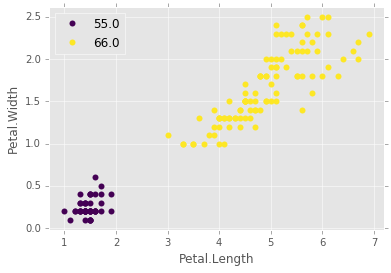

In [65]:
groups = final_df.groupby('Cluster')

# Plot
colors = pd.tools.plotting._get_standard_colors(len(groups), colormap='viridis')

fig, ax = plt.subplots()
ax.set_color_cycle(colors)
ax.margins(0.05)
for name, group in groups:
    ax.plot(group['Petal.Length'], group['Petal.Width'], marker='o', linestyle='', ms=6, markeredgewidth=0.0, label=name)
ax.legend(numpoints=1, loc='upper left')
ax.set_xlabel('Petal.Length')
ax.set_ylabel('Petal.Width')

plt.show()

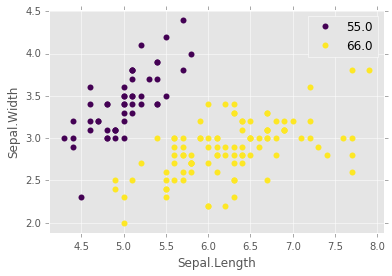

In [66]:
groups = final_df.groupby('Cluster')

# Plot
colors = pd.tools.plotting._get_standard_colors(len(groups), colormap='viridis')

fig, ax = plt.subplots()
ax.set_color_cycle(colors)
ax.margins(0.05)
for name, group in groups:
    ax.plot(group['Sepal.Length'], group['Sepal.Width'], marker='o', linestyle='', ms=6, markeredgewidth=0.0, label=name)
ax.legend(numpoints=1, loc='upper right')
ax.set_xlabel('Sepal.Length')
ax.set_ylabel('Sepal.Width')

plt.show()

On obtient finalement 2 clusters, bien séparés sur les 2 graphiques. Le résultat est donc rassurant. Néanmoins, on peut remarquer qu'on ne réussit pas à retrouver 3 clusters correspondant aux 3 types d'iris initialement présentes dans la base de données. Pour ce faire, après quelques tests de diminution du paramètre d'agrégation, nous avons remarqué qu'il fallait un paramètre égal à 0.17 mais qu'avec 0.15 nous obtenions 4 clusters et avec 0.20 nous en obtenions 2. En augmentant le paramètre d'agrégation nous obtenons toujours 2 clusters. Ainsi, sans a priori sur les données, nous pouvons considérer qu'avec notre méthode nous n'avons que très peu de "chance" de tomber sur 3 clusters.